# Model
## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Images
from PIL import Image
from matplotlib import image
from IPython.display import display

# Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam

## Utility functions

In [2]:
def plot_face_center(x, coordinates):
    """Plot face with marked center.
    
    Where x is numpy array reprezenting a picture
    """
    fig, ax = plt.subplots(sharex=True,sharey=True)
    ax.imshow(x[:,:,:].astype('uint8'))
    ax.scatter(coordinates[0], coordinates[1], marker='X', c='r', s=10)


def plot_faces(X, Y, rows_number=5, columns_number=5):
    """Plot rows_number * columns_number faces with marked center.
    
    Faces are choosen randomly.
    """
    n = 0
    irand=np.random.choice(Y.shape[0],rows_number*columns_number)
    fig, ax = plt.subplots(rows_number,columns_number,sharex=True,sharey=True,figsize=[rows_number*2,columns_number*2])
    for row in range(rows_number):
        for col in range(columns_number):
            ax[row,col].imshow(X[irand[n],:,:,:].astype('uint8'))
            ax[row,col].scatter(Y[irand[n],0], Y[irand[n],1], marker='X',c='r',s=10)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
            n += 1


def plot_prediction(x, y, y_pred):
    """Plot face with marked labeled and predicted centre.
    
    Where x is numpy array reprezenting a picture
    """
    fig, ax = plt.subplots(sharex=True,sharey=True)
    ax.imshow(x[:,:,:].astype('uint8'))
    ax.scatter(y[0], y[1], marker='X', c='r', s=10)
    ax.scatter(y_pred[0], y_pred[1], marker='X', c='r', s=10)


def plot_predictions(X, Y, Y_pred, rows_number=5, columns_number=5):
    """Plot face with marked labeled and predicted centre.
    
    Where x is numpy array reprezenting a picture
    """
    n = 0
    irand=np.random.choice(Y.shape[0],rows_number*columns_number)
    fig, ax = plt.subplots(rows_number,columns_number,sharex=True,sharey=True,figsize=[rows_number*2,columns_number*2])
    for row in range(rows_number):
        for col in range(columns_number):
            ax[row,col].imshow(X[irand[n],:,:,:].astype('uint8'))
            ax[row,col].scatter(Y[irand[n],0], Y[irand[n],1], marker='X',c='r',s=10)
            ax[row,col].scatter(Y_pred[irand[n],0], Y_pred[irand[n],1], marker='X',c='b',s=10)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
            n += 1


def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of  metrics vs. epoch
    
    Arguments:
    epochs -- epochs list
    hist -- training history given as pd.DataFrame
    list_of_metics -- list of metrics to plot
  
    metrics names should be as given in: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
    """    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    # Plot given metrics
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

## Load data

In [3]:
data_path = os.path.join(os.getcwd(), "data")
print(os.listdir(data_path))
# For small data
# X = np.load(os.path.join(data_path, 'X_small.npy'))
# Y = np.load(os.path.join(data_path, 'Y_small.npy'))
X = np.load(os.path.join(data_path, 'X.npy'))
Y = np.load(os.path.join(data_path, 'Y.npy'))

['Face Images with Marked Landmark Point', 'Facial Keypoints', 'X.npy', 'X_small.npy', 'Y.npy', 'Y_small.npy']


## Quick peak at data:

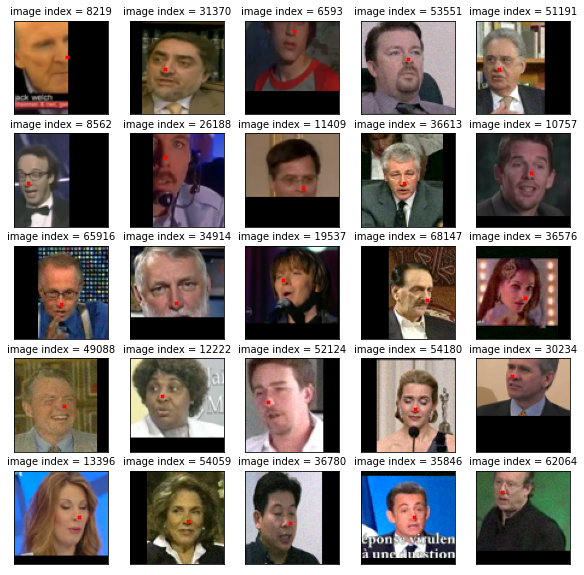

In [4]:
plot_faces(X, Y)

In [5]:
print(X.shape)
print(Y.shape)

(70900, 78, 78, 3)
(70900, 2)


## Normalize data and scale target

In [6]:
# Make sure that X, Y are in range [0, 1]
picture_size=78
X = X / 255.0
Y = Y / picture_size

In [9]:
print(X.max(), X.min(), X.mean())
print(Y.max(), Y.min(), Y.mean())

1.0 0.0 0.3126183156028107
0.978125 0.018880208333333332 0.48194869218183367


## Split data into training, validation and test sets

In [7]:
# test set size
test_size = 2000
# train_size = 100
# Cross Validation set size
val_size = 6000
# val_size = 200
random_seed=21
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size / X.shape[0], random_state=random_seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size / X_train.shape[0], random_state=random_seed)

In [8]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(62900, 78, 78, 3) (62900, 2)
(6000, 78, 78, 3) (6000, 2)
(2000, 78, 78, 3) (2000, 2)


## Simple model

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', activation='tanh', input_shape=(picture_size, picture_size, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [24]:
opt = Adam()
model.compile(loss='mean_squared_error', optimizer=opt)

In [25]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=3, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/3
391/391 [==============================] - 251s 641ms/step - loss: 0.0127 - val_loss: 0.0095
Epoch 2/3
391/391 [==============================] - 240s 613ms/step - loss: 0.0097 - val_loss: 0.0085
Epoch 3/3
391/391 [==============================] - 238s 608ms/step - loss: 0.0088 - val_loss: 0.0078


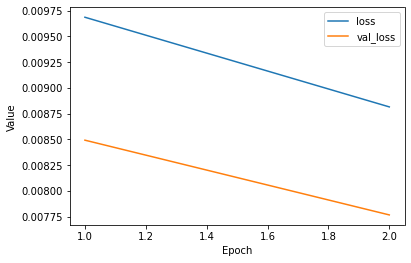

In [28]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['loss', 'val_loss']
plot_curve(epochs, hist, metrics)

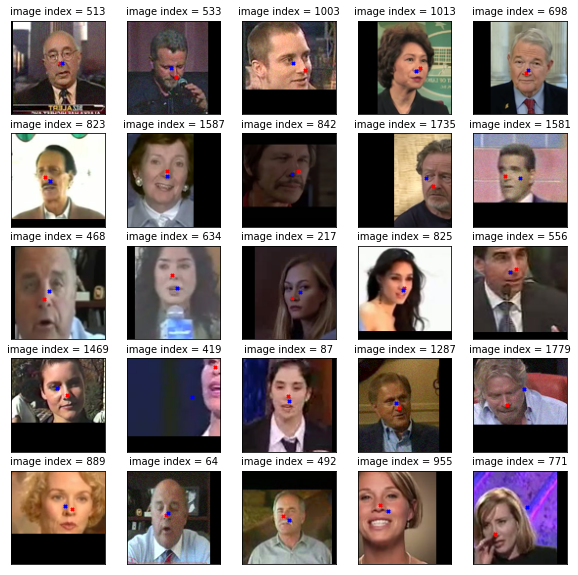

In [37]:
Y_test_pred = model.predict(X_test)
plot_predictions(X_test * 255.0, Y_test * picture_size, Y_test_pred * picture_size)

In [13]:
multiply_sizes=3
model = Sequential()
model.add(MaxPool2D(pool_size=(2, 2), input_shape=(picture_size, picture_size, 3)))
model.add(Conv2D(kernel_size=(4, 4), activation='relu', filters=20 * multiply_sizes))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(kernel_size=(3, 3), activation='relu', filters=40 * multiply_sizes))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=(3, 3), activation='relu', filters=60 * multiply_sizes))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=(2, 2), activation='relu', filters=80 * multiply_sizes))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(256, activation='tanh'))
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='sigmoid'))
model.output_shape

(None, 2)

In [10]:
lr=1e-4
opt = Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=opt)

In [11]:
# Use mini batch gradient descent
# batch size should fit in GPU memory
b_size = 64
history = model.fit(X_train, Y_train, batch_size=b_size, epochs=3, validation_data = (X_val, Y_val))

Epoch 1/3
983/983 [==============================] - 76s 78ms/step - loss: 0.0123 - val_loss: 0.0090
Epoch 2/3
983/983 [==============================] - 69s 71ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 3/3
983/983 [==============================] - 67s 68ms/step - loss: 0.0060 - val_loss: 0.0056


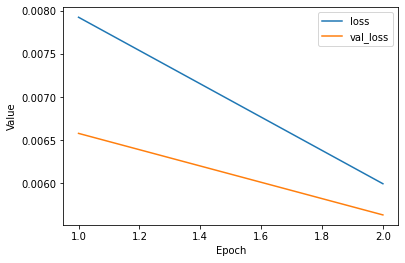

In [12]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['loss', 'val_loss']
plot_curve(epochs, hist, metrics)

In [ ]:
b_size = 64
history = model.fit(X_train, Y_train, batch_size=b_size, epochs=3, validation_data = (X_val, Y_val))